# Portfolio Optimization and Risk Analysis Using Monte Carlo Simulation

## 🎯 Objective

The goal of this project is to construct an optimized portfolio using a combination of T-Bills, Apple (AAPL), and Nvidia (NVDA), and then evaluate the risk profile of the portfolio using Monte Carlo simulation. We will assess the difference in Value-at-Risk (VaR) estimation under normal and fat-tailed return distributions to highlight the importance of accounting for extreme events in financial modeling.

## 🔁 Project Steps

### **Data Collection**
- Download historical daily price data for:

| Asset   | Type                      | Purpose                                              |
|---------|---------------------------|------------------------------------------------------|
| **PG**  | Equity (Consumer Staples) | Defensive stock for stability and consistent returns |
| **NVDA**| Equity (High-beta Tech)   | Exposure to volatility and AI/semiconductors         |
| **SHV** | Risk-free Asset           | Base of the portfolio                                |
| **GLD** | Commodity ETF (Gold)      | Diversification & safe-haven asset                   |

### **Return Calculation**
- Compute daily log returns for each Asset.
- T-Bills will serve as the **risk-free component** of the portfolio.

### **Portfolio Optimization**
- Apply **Mean-Variance Optimization (Markowitz Framework)** to:
  - Calculate the efficient frontier.
  - Identify the portfolio with the maximum Sharpe Ratio.
- Optionally compare with **Risk Parity** approach.

### **Portfolio Simulation**
- Simulate the portfolio's future returns using:
  - **Multivariate Normal Distribution** (Gaussian).
  - **Fat-tailed Distribution** (e.g., Student's t-distribution).
- Generate a large number of return paths using **Monte Carlo Simulation**.

### **Value-at-Risk (VaR) Estimation**
- Calculate and compare 1-day VaR for:
  - Normal distribution.
  - Fat-tailed distribution.
- Highlight how the assumption of normality can underestimate tail risk.

### **Visualization**
- Plot:
  - Historical prices and returns.
  - Efficient frontier.
  - Simulated distribution of portfolio returns.
  - VaR comparisons.

### **Conclusion**
- Discuss findings.
- Emphasize the trade-offs between simplicity and accuracy in financial risk modeling.

# Import libraries

In [21]:
import yfinance as yf
import datetime
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

# Data Collection

In [1]:
# Definir la fecha de hoy
Today = datetime.datetime.today().strftime('%Y-%m-%d')

# Tickers de los activos
tickers = ['PG', 'NVDA', 'SHV', 'GLD']  # Apple, Nvidia, S&P 500 ETF, Gold ETF

# Descargar los datos de los activos desde el 1 de enero de 2021 hasta la fecha actual (Today)
Price_df = yf.download(tickers, start="2021-01-01", end=Today,group_by='column', auto_adjust=False)['Adj Close']

# Mostrar los primeros datos descargados
Price_df.head()

NameError: name 'datetime' is not defined

# Return Calculation


### Why We Use Daily Log Returns

In financial analysis, **daily log returns** are commonly used for the following reasons:

1. **Lognormal Distribution Assumption**: Asset prices are assumed to follow a lognormal distribution, meaning the log returns (logarithmic differences between consecutive prices) tend to follow a normal distribution, which is easier to model and analyze.

2. **Time Continuity**: Log returns are additive over time, which is particularly useful for modeling and analyzing compounded returns over multiple periods. This makes it easier to calculate cumulative returns over time.

3. **Stability in Stochastic Models**: Log returns are more stable and better suited for stochastic models like **Geometric Brownian Motion** (used in Black-Scholes) and **Cox-Ingersoll-Ross** models, where they exhibit properties like normal distribution and independence.

4. **Handling Volatility**: Log returns deal better with volatility and the asymmetry seen in asset price movements (i.e., large drops and rises don't cancel each other out as they would in simple returns), ensuring more accurate modeling over time.

In summary, **daily log returns** provide a consistent, mathematically convenient way to model and analyze asset price movements, especially for longer periods and in stochastic modeling scenarios.

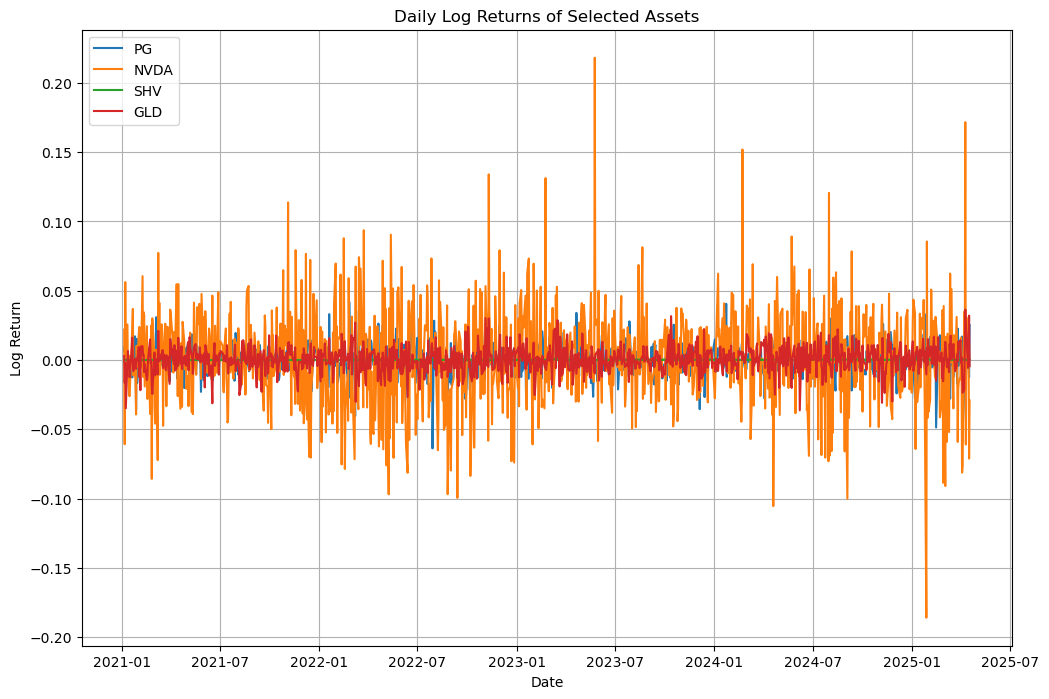

Correlation matrix:
 Ticker       GLD      NVDA        PG       SHV
Ticker                                        
GLD     1.000000  0.104348  0.102688  0.191484
NVDA    0.104348  1.000000  0.034334  0.047841
PG      0.102688  0.034334  1.000000  0.112343
SHV     0.191484  0.047841  0.112343  1.000000

Missing values in the returns data:
 Ticker
GLD     1
NVDA    1
PG      1
SHV     1
dtype: int64


In [3]:
# Calculate the daily log returns
returns = np.log(Price_df / Price_df.shift(1))

# Display the first few calculated returns
returns.head()

# Plot the daily log returns
plt.figure(figsize=(12, 8))
for ticker in tickers:
    plt.plot(returns.index, returns[ticker], label=ticker)

plt.title("Daily Log Returns of Selected Assets")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.show()

# Check the correlation between assets
correlation_matrix = returns.corr()
print("Correlation matrix:\n", correlation_matrix)

# Check for missing values
missing_values = returns.isnull().sum()
print("\nMissing values in the returns data:\n", missing_values)

# Portfolio optimization

### 📈 Theoretical Framework: Portfolio Optimization via Monte Carlo Simulation

This procedure implements a **mean-variance optimization** approach to identify the optimal asset allocation in a portfolio, based on modern portfolio theory (MPT) introduced by Harry Markowitz.

#### 1. Estimating Inputs

- **Expected Returns**:  
  Historical log returns are used to estimate the expected return of each asset. These are typically daily returns which are then **annualized** by multiplying by the number of trading days in a year (commonly 252).

- **Covariance Matrix**:  
  The covariance matrix captures the variances and covariances of asset returns, reflecting how the assets move together. This too is **annualized**.

- **Risk-Free Rate**:  
  A Treasury ETF (e.g., SHV) is used as a proxy for the risk-free rate. Its average return is used to compute Sharpe Ratios.

#### 2. Monte Carlo Portfolio Simulation

- A large number of **random portfolios** are generated by assigning random weights to each asset (constrained to sum to 1).
  
- For each portfolio, the following metrics are calculated:
  - **Expected Return**: Weighted average of the annualized asset returns.
  - **Volatility**: Portfolio standard deviation computed using the covariance matrix and asset weights.
  - **Sharpe Ratio**: Measures the excess return per unit of risk:
    $$
    \text{Sharpe Ratio} = \frac{E[R_p] - R_f}{\sigma_p}
    $$
    where $ E[R_p] $ is the expected return of the portfolio, $ R_f $ is the risk-free rate, and $ \sigma_p $ is the portfolio volatility.

#### 3. Optimization Objective

- By simulating thousands of random portfolios, we aim to **identify the portfolio with the highest Sharpe Ratio**, which offers the best risk-adjusted return.

- This approach also allows the **visualization of the efficient frontier**, representing the set of optimal portfolios that offer the highest expected return for a given level of risk.

#### Why Monte Carlo?

Monte Carlo simulation enables exploration of a vast solution space without assuming a predefined structure. This is especially useful when the number of assets increases and the optimization landscape becomes complex or non-convex.

In [4]:
returns = returns.dropna()
expected_returns = returns.mean()
cov_matrix = returns.cov()
rf = expected_returns['SHV'].mean()

trading_days = 252  # Número típico de días de trading en un año
annualized_returns = expected_returns * trading_days
annualized_cov_matrix = cov_matrix * trading_days

# Simulate portfolios
num_portfolios = 50000
results = np.zeros((3, num_portfolios))
weights_record = []
portfolio_returns = []
portfolio_volatility = []
portfolio_sharpe_ratio = []

for i in range(num_portfolios):
    # Generate random weights that sum to 1
    weights = np.random.random(len(Price_df.columns))
    weights /= np.sum(weights) #Normalize to sum 1
    weights_record.append(weights)

    # Portfolio return
    port_return = np.dot(weights, annualized_returns)

    # Portfolio volatility (standard deviation)
    port_volatility = np.dot(weights.T, np.dot(annualized_cov_matrix, weights))

    # Sharpe ratio assuming SHV as risk-free (risk-free return ≈ mean of SHV)

    sharpe_ratio = (port_return - rf) / np.sqrt(port_volatility)

    # Store results: return, volatility, sharpe
    results[0, i] = port_volatility
    results[1, i] = port_return
    results[2, i] = sharpe_ratio
        
    portfolio_returns.append(port_return)
    portfolio_volatility.append(port_volatility)
    portfolio_sharpe_ratio.append(sharpe_ratio)



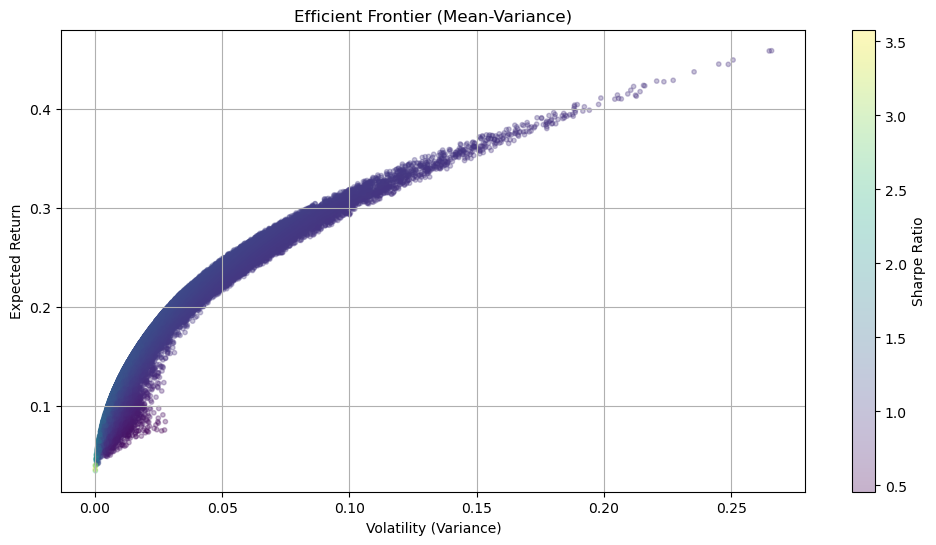

In [5]:
#Plot Efficient Frontier
plt.figure(figsize=(12, 6))
plt.scatter(results[0, :], results[1, :], c=results[2, :], cmap='viridis', marker='o', s=10, alpha=0.3)
plt.xlabel('Volatility (Variance)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier (Mean-Variance)')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.show()

In [6]:
# Convert results to numpy arrays for easier handling
portfolio_returns = np.array(portfolio_returns)
portfolio_volatility = np.array(portfolio_volatility)
portfolio_sharpe_ratio = np.array(portfolio_sharpe_ratio)

# Find the index of the portfolio with the maximum Sharpe Ratio
max_sharpe_idx = np.argmax(portfolio_sharpe_ratio)

# Get the weights of the optimal portfolio
optimal_weights = weights_record[max_sharpe_idx]

# Get the return, volatility, and Sharpe Ratio of the optimal portfolio
max_sharpe_return = portfolio_returns[max_sharpe_idx]
max_sharpe_volatility = portfolio_volatility[max_sharpe_idx]
max_sharpe_ratio_value = portfolio_sharpe_ratio[max_sharpe_idx]

In [7]:
# Display the optimal portfolio details
real_return = (np.exp(max_sharpe_return) - 1)
print("Optimal Portfolio Weights:")
for asset, weight in zip(expected_returns.index, optimal_weights):
    print(f"{asset}: {weight:.2%}")
print(f"\nExpected Return: {real_return:.2%}")
print(f"Volatility: {max_sharpe_volatility:.2%}")
print(f"Sharpe Ratio: {max_sharpe_ratio_value:.2f}")

Optimal Portfolio Weights:
GLD: 1.03%
NVDA: 1.26%
PG: 3.19%
SHV: 94.51%

Expected Return: 3.69%
Volatility: 0.01%
Sharpe Ratio: 3.58


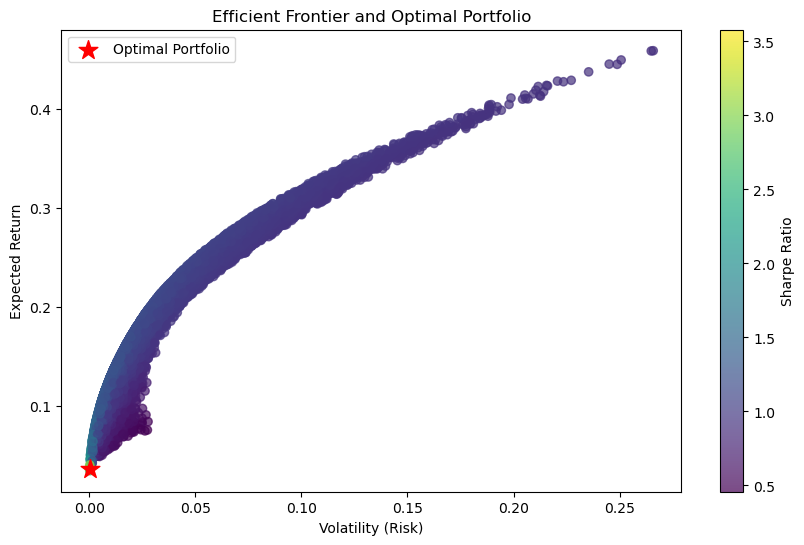

In [8]:
# Plot the efficient frontier
plt.figure(figsize=(10, 6))

# Scatter plot all the simulated portfolios
# Color represents the Sharpe Ratio of each portfolio
plt.scatter(portfolio_volatility, portfolio_returns, c=portfolio_sharpe_ratio, cmap='viridis', marker='o', alpha=0.7)

# Add a color bar that represents the Sharpe Ratio values
plt.colorbar(label='Sharpe Ratio')

# Highlight the optimal portfolio with the highest Sharpe Ratio
plt.scatter(max_sharpe_volatility, max_sharpe_return, color='red', marker='*', s=200, label="Optimal Portfolio")

# Add labels and title to the plot
plt.title("Efficient Frontier and Optimal Portfolio")
plt.xlabel("Volatility (Risk)")
plt.ylabel("Expected Return")
plt.legend(loc='upper left')

# Show the plot
plt.show()

# Portfolio Simulation

## Normal Distribution

### 🔮 Theoretical Framework: Monte Carlo Simulation of Portfolio Returns

This section models future returns of a portfolio using a **Monte Carlo simulation** based on the **multivariate normal distribution** of asset returns. This allows for estimation of expected performance and risk under uncertainty.

#### 1. Assumptions and Parameters

- The simulation assumes that future asset returns follow a **multivariate normal distribution** with:
  - **Mean vector**: Expected returns of each asset (typically estimated from historical data).
  - **Covariance matrix**: Captures the joint variability between assets.

- The portfolio is simulated for a set horizon, e.g., **3 years** (756 trading days), with **3,000 return paths**.

#### 2. Generating Simulated Return Paths

- Each simulation generates a path of daily returns for each asset, drawn from the joint distribution.
- These daily asset returns are then combined using the **portfolio's optimal weights** (previously computed), producing simulated portfolio-level daily returns.

#### 3. Cumulative and Annualized Returns

- The **cumulative return** for each simulation is computed by compounding the daily returns across the time horizon:
  $$
  R_{\text{cumulative}} = \prod_{t=1}^{T} (1 + r_t) - 1
  $$

- The **annualized return** is then calculated using:
  $$
  R_{\text{annualized}} = (1 + R_{\text{cumulative}})^{1 / \text{years}} - 1
  $$

#### 4. Estimating Risk and Return

- From all simulations, the **mean** and **standard deviation** of the annualized returns are calculated.
- A **confidence interval** is computed using:
  $$
  \text{CI}_{99.7\%} = \mu \pm 3\sigma
  $$
  assuming normally distributed annualized returns (empirical rule).

#### 5. Interpretation

This simulation provides a **distribution of possible outcomes** for the portfolio over the next 3 years, helping assess:
- The likelihood of achieving a target return.
- The worst- and best-case scenarios (within confidence bounds).
- The level of uncertainty or dispersion around the expected return.

This technique is widely used in **risk management**, **asset allocation**, and **stress testing** investment strategies.

In [25]:
# Define the parameters for the simulation
num_simulations = 3000  # Number of Monte Carlo simulations (paths)
num_days = 756
years = num_days/252

# Generate random returns using a multivariate normal distribution
# Using the expected returns and the covariance matrix
simulated_returns = np.random.multivariate_normal(expected_returns, cov_matrix, (num_simulations, num_days))

# Simulate portfolio paths by multiplying by portfolio weights
portfolio_simulated_returns = np.dot(simulated_returns, optimal_weights)

# To calculate the cumulative returns, we use the formula:
# (1 + return1) * (1 + return2) * ... * (1 + returnN) - 1
portfolio_cumulative_returns = np.cumprod(1 + portfolio_simulated_returns, axis=1) - 1

# Annualize the returns (assuming the simulations are for 252 days)
annualized_returns = (1 + portfolio_cumulative_returns) ** (1 / years) - 1  # For 3 years

# Calculate the mean and standard deviation of the annualized returns
mean_annualized_return = np.mean(annualized_returns)
std_annualized_return = np.std(annualized_returns)

# Calculate the confidence interval (mean ± 3 standard deviations)
lower_bound = mean_annualized_return - 3 * std_annualized_return
upper_bound = mean_annualized_return + 3 * std_annualized_return

# Display the results
print(f"Mean annualized return: {mean_annualized_return * 100:.2f}%")
print(f"Confidence interval (± 3 standard deviations): {lower_bound * 100:.2f}% to {upper_bound * 100:.2f}%")

Mean annualized return: 1.83%
Confidence interval (± 3 standard deviations): -1.59% to 5.25%


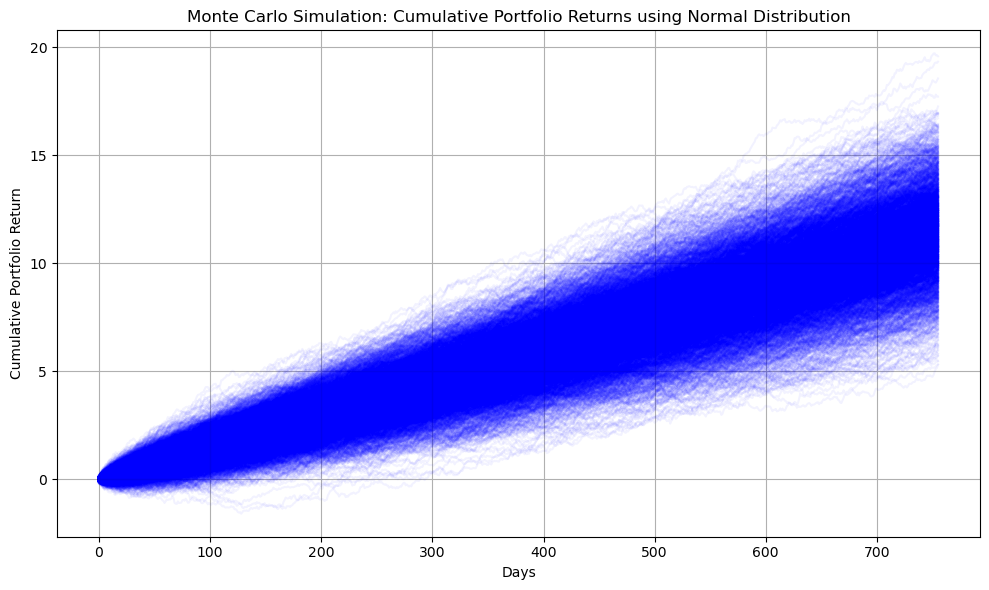

In [27]:
# Compute cumulative return paths for each simulation
# Cumulative return = product of (1 + daily return) over time
# portfolio_cumulative_paths = np.cumprod(1 + portfolio_simulated_returns, axis=1)
# Plot the simulated cumulative portfolio returns
plt.figure(figsize=(10, 6))
plt.plot(portfolio_cumulative_returns.T*100, color='blue', alpha=0.05)  # Transpose for plotting
plt.title("Monte Carlo Simulation: Cumulative Portfolio Returns using Normal Distribution")
plt.xlabel("Days")
plt.ylabel("Cumulative Portfolio Return")
plt.grid(True)
plt.tight_layout()
plt.show()

## T-dist

### 📉 Monte Carlo Simulation Using the Student's t-Distribution

In this section, we repeated the Monte Carlo simulation of portfolio returns, but instead of assuming a normal distribution, we used the **Student’s t-distribution**.

#### Why Use the t-Distribution?

The t-distribution is characterized by **heavier tails** compared to the normal distribution. This means it assigns a higher probability to extreme events (both positive and negative returns), making it more suitable for financial modeling, where **tail risk** is often underestimated by the normal distribution.

By simulating returns using the t-distribution:

- We account for the possibility of **extreme market movements**.
- We obtain a more **realistic distribution of potential outcomes**, especially under high volatility scenarios.
- The risk measures derived (e.g., Value at Risk or expected shortfall) become **more conservative and robust**.

This approach helps improve the accuracy of risk estimation and enhances the reliability of stress testing and scenario analysis in portfolio management.

In [28]:
# Simulation parameters
num_simulations = 10000
num_days = 756  # 3 years of trading days
years = num_days / 252
dof = 4  # degrees of freedom

# Simulate t-distributed standard returns (mean=0, std=1)
t_raw = np.random.standard_t(dof, size=(num_simulations, num_days, len(expected_returns)))

# Apply Cholesky decomposition to correlate the returns
L = np.linalg.cholesky(cov_matrix)
t_correlated = np.einsum('ijk,kl->ijl', t_raw, L.T)

# Add expected returns (daily) to get total simulated returns
# Note: expected_returns must be daily returns (not annualized)
t_simulated_returns = t_correlated + expected_returns.values  # Broadcasting mean into shape

# Multiply by portfolio weights to get portfolio returns
portfolio_simulated_returns_t = np.dot(t_simulated_returns, optimal_weights)

# Compute cumulative returns and annualize
portfolio_cumulative_returns_t = np.cumprod(1 + portfolio_simulated_returns_t, axis=1) - 1
annualized_returns_t = (1 + portfolio_cumulative_returns_t) ** (1 / years) - 1

# Compute stats
mean_annualized_return_t = np.mean(annualized_returns_t)
std_annualized_return_t = np.std(annualized_returns_t)
lower_bound_t = np.percentile(annualized_returns_t, 2.5)
upper_bound_t = np.percentile(annualized_returns_t, 97.5)

# Print results
print(f"Mean annualized return (t-distribution): {mean_annualized_return_t * 100:.2f}%")
print(f"95% Confidence interval (t-distribution): {lower_bound_t * 100:.2f}% to {upper_bound_t * 100:.2f}%")

# # Plot histogram
# plt.figure(figsize=(10, 6))
# plt.hist(annualized_returns_t * 100, bins=50, color='red', alpha=0.7, label="t-distribution")
# plt.axvline(mean_annualized_return_t * 100, color='red', linestyle='dashed', linewidth=2, label="Mean (t-dist)")
# plt.axvline(lower_bound_t * 100, color='green', linestyle='dashed', linewidth=2, label="95% CI lower bound")
# plt.axvline(upper_bound_t * 100, color='green', linestyle='dashed', linewidth=2, label="95% CI upper bound")
# plt.title("Distribution of Simulated Annualized Returns (3 years) - t-distribution")
# plt.xlabel("Annualized Return (%)")
# plt.ylabel("Frequency")
# plt.legend()
# plt.show()

Mean annualized return (t-distribution): 1.83%
95% Confidence interval (t-distribution): -0.00% to 4.34%


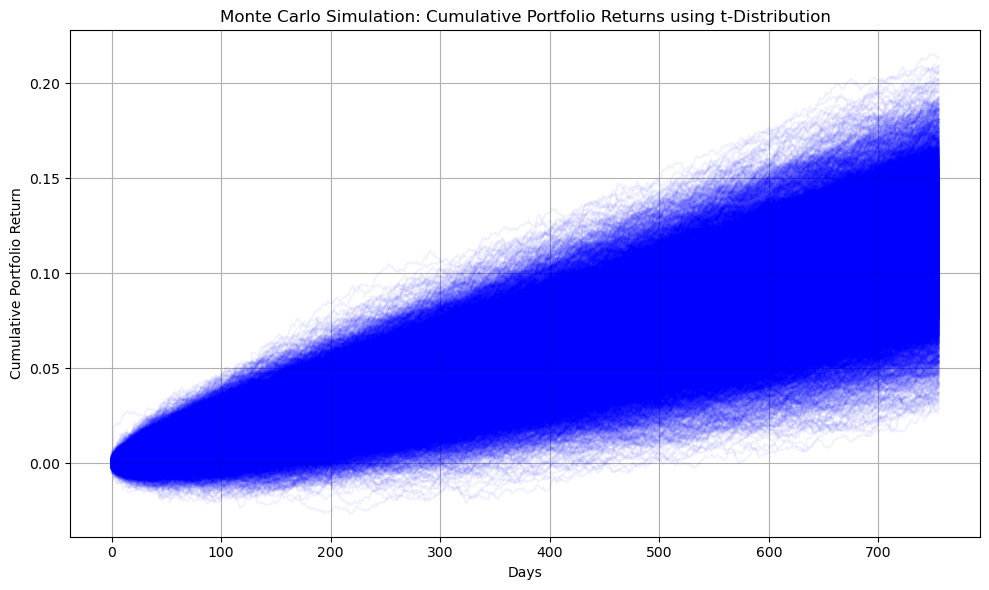

In [29]:
# Compute cumulative return paths for each simulation
# Cumulative return = product of (1 + daily return) over time
# portfolio_cumulative_paths_t = np.cumprod(1 + portfolio_simulated_returns_t, axis=1)

# Plot the simulated cumulative portfolio returns
plt.figure(figsize=(10, 6))
plt.plot(portfolio_cumulative_returns_t.T, color='blue', alpha=0.05)  # Transpose for plotting
plt.title("Monte Carlo Simulation: Cumulative Portfolio Returns using t-Distribution")
plt.xlabel("Days")
plt.ylabel("Cumulative Portfolio Return")
plt.grid(True)
plt.tight_layout()
plt.show()

# Value at Risk (VaR) Estimation

### 📊 Calculating Value at Risk (VaR) and Conditional Value at Risk (CVaR)

In this section, we compute two key risk metrics: **Value at Risk (VaR)** and **Conditional Value at Risk (CVaR)**, also known as **Expected Shortfall**.


#### 🛑 What is VaR?

**Value at Risk (VaR)** measures the maximum expected loss over a specified time period at a given confidence level. For example, a 1-day 95% VaR of -2% means that there is a 95% chance the portfolio will not lose more than 2% in a single day.


#### 📉 What is CVaR?

**Conditional Value at Risk (CVaR)**, or **Expected Shortfall**, is the **expected loss given that the loss exceeds the VaR threshold**. It gives more insight into the tail of the loss distribution and is considered a more informative and coherent risk measure.


#### 🧮 Methods to Calculate VaR and CVaR

There are **three main approaches** to calculate VaR and CVaR:

1. **Parametric (Variance-Covariance Method):**  
   Assumes that returns are normally distributed and uses the mean and standard deviation to estimate risk.

2. **Historical Simulation:**  
   Uses historical return data to estimate the empirical distribution of losses.

3. **Monte Carlo Simulation:**  
   Simulates thousands of possible return paths to build a distribution and estimate risk metrics.


#### ✅ Our Approach

We will use the **Monte Carlo Simulation** results from our portfolio return modeling to estimate the **1-day VaR and CVaR** at a 95% confidence level. This allows us to capture more complex dynamics and non-linear relationships in the portfolio, providing a more realistic view of potential losses.

In [31]:
# Nivel de confianza
confidence_level = 95
alpha = 100 - confidence_level  # e.g., 5%

# --- Para distribución Normal (simulada) ---
# 1. Obtener todos los retornos al final del periodo simulado
sim_returns_normal = portfolio_simulated_returns[:, -1]

# 2. Calcular el umbral VaR
VaR_normal = np.percentile(sim_returns_normal, alpha)

# 3. Calcular el CVaR como el promedio de las pérdidas por debajo del VaR
CVaR_normal = -np.mean(sim_returns_normal[sim_returns_normal <= VaR_normal])


# --- Para distribución t (simulada) ---
sim_returns_t = portfolio_simulated_returns_t[:, -1]
VaR_t = np.percentile(sim_returns_t, alpha)
CVaR_t = -np.mean(sim_returns_t[sim_returns_t <= VaR_t])


# Mostrar resultados
print(f"1-day VaR (Normal): {abs(VaR_normal) * 100:.2f}%")
print(f"1-day CVaR (Normal): {CVaR_normal * 100:.2f}%\n")

print(f"1-day VaR (t-distribution): {abs(VaR_t) * 100:.2f}%")
print(f"1-day CVaR (t-distribution): {CVaR_t * 100:.2f}%")

1-day VaR (Normal): 0.09%
1-day CVaR (Normal): 0.12%

1-day VaR (t-distribution): 0.13%
1-day CVaR (t-distribution): 0.18%


## 🧾 Portfolio Analysis Conclusions

Based on the simulation and optimization results, we can draw several key conclusions about the constructed portfolio:


### ✅ Portfolio Composition

The portfolio is heavily tilted toward the risk-free asset (represented by SHV), with minimal allocations to equities and gold. This suggests the optimization process favored capital preservation and low volatility, likely due to the high Sharpe ratio associated with SHV relative to the riskier assets.


### 📈 Return and Risk Expectations

Despite the conservative asset allocation, the portfolio achieves a positive expected return with extremely low volatility. This reflects a trade-off prioritizing stability over aggressive growth, a characteristic often suitable for risk-averse investors or capital preservation strategies.


### 📊 Monte Carlo Simulations

Simulations were performed under two assumptions: normally distributed returns and fat-tailed returns (Student's t-distribution).

- The results under both distributions are consistent, showing a low average annualized return with a relatively tight range of outcomes.
- The t-distribution, with its heavier tails, slightly increases the probability of more extreme events compared to the normal distribution, which is evident in the wider confidence interval.


### ⚠️ Risk Metrics: VaR and CVaR

To assess short-term risk, 1-day Value at Risk (VaR) and Conditional Value at Risk (CVaR) were calculated using the Monte Carlo simulated returns.

- The risk measures derived from the t-distribution were marginally higher than those from the normal distribution, reinforcing the idea that normal models may underestimate tail risks.
- Nonetheless, due to the low volatility and high exposure to the risk-free asset, both VaR and CVaR remain modest in absolute terms.


### 📌 Final Thoughts

The portfolio exhibits characteristics of a **capital-preservation strategy**, emphasizing minimal risk and modest returns. While this approach limits upside potential, it also provides resilience against market shocks. The inclusion of t-distributed simulations allows for a more robust understanding of potential losses under more realistic, non-normal conditions.